<a href="https://colab.research.google.com/github/alexjochs/ECE_539_Penguins/blob/model/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import mean_squared_error
from keras.initializers import RandomNormal
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.models import Model,Sequential
from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
K.clear_session()
root = r'/content'
gdrive_data_filepath = r"/content/drive/MyDrive/Penguin_counting/data_peng_watch"
print(root)
print(gdrive_data_filepath)
os.chdir(root)

/content
/content/drive/MyDrive/Penguin_counting/data_peng_watch


In [4]:
def get_new_batch(target=None):
    assert target is not None, f"can't get specific folder: {target} and load all data"
    tgz_name = target + '.tgz'
    folder_path = os.path.join(gdrive_data_filepath, tgz_name)
    !tar -xzf {folder_path} -C {root}

In [5]:
MASTER_LIST = ['BAILa', 'DAMOa', 'HALFb', 'HALFc', 'LOCKb', 'MAIVb', 'MAIVc', 'NEKOa', 'NEKOb', 'NEKOc', 'PETEc', 'PETEd', 'PETEe', 'PETEf', 'SPIGa', 'GEORa']
test = [MASTER_LIST, [x + '_gt' for x in MASTER_LIST]]
# slice working list to split workload between us
working_list = MASTER_LIST[:] # TODO

In [ ]:
# TODO
# for x in working_list:
#     !rm -rf {x}
#     !rm -rf {x}_gt
!rm -rf /content/content
#!rm -rf /content/sample_data/

In [6]:
# Extract all images
for (data_split_name, data_split_name_gt) in zip(test[0][:1], test[1][:1]):
    if not os.path.exists(data_split_name):
        get_new_batch(data_split_name)
        get_new_batch(data_split_name_gt)

tar: Removing leading `/' from member names
tar: Removing leading `/' from member names


In [9]:
path_sets = [root + '/content/' + x for x in test[0][:1]]
path_sets

['/content/content/BAILa']

In [10]:
img_paths = []

for path in path_sets:
    
    for img_path in glob.glob(os.path.join(path, '*.JPG')):

        out_path = img_path[:22] + '_gt' + img_path[22:].replace('.JPG','_gt.h5') # '/content' + 
        output = get_output(out_path)

        if output.sum() > 0:
            img_paths.append(str(img_path))
        
print("Total images : ", len(img_paths))

Total images :  1012


In [7]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    im = im.resize((800, 600), Image.ANTIALIAS)

    im = np.array(im)
    
    # im = im/255.0
    
    # im[:,:,0]=(im[:,:,0]-0.485)/0.229
    # im[:,:,1]=(im[:,:,1]-0.456)/0.224
    # im[:,:,2]=(im[:,:,2]-0.406)/0.225
    image = tf.image.convert_image_dtype(im, tf.float32)
    new_image = tf.image.per_image_standardization(image)
    new_image = tf.clip_by_value(new_image, 0.0, 1.0)

    # print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return new_image

def get_input(path):
    path = path #[0] 
    img = create_img(path)
    return(img)
    
    
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    # img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    # img = np.expand_dims(img, axis=img.ndim)
    
    # print(img.shape)
    
    return target
    
    
    
def preprocess_input(image,target):
    #crop image
    #crop target
    #resize target
    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    
    
    if random.randint(0,9)<= -1:            
            dx = int(random.randint(0,1)*image.shape[0]*1./2)
            dy = int(random.randint(0,1)*image.shape[1]*1./2)
    else:
            dx = int(random.random()*image.shape[0]*1./2)
            dy = int(random.random()*image.shape[1]*1./2)

    #print(crop_size , dx , dy)
    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    
    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
    #print(img.shape)

    return(img,target_aug)
    
   

In [11]:
#Image data generator 
def image_generator(files, batch_size = 64):
    
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
        for input in input_path:
        
            inputt = get_input(input)
            # image_string = tf.io.read_file(input_path[0])
            # image = tf.image.decode_jpeg(image_string, channels=3)
            # image = tf.image.convert_image_dtype(image, tf.float32)

            # image = tf.image.resize(image, [300, 400])
            out_path = input[:22] + '_gt' + input[22:].replace('.JPG','_gt.h5') # '/content' + 
            # if not os.path.exists(out_path):
            #     continue
            output = get_output(out_path)
                
        
            batch_input += [inputt]
            batch_output += [output]
    

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )


In [ ]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [12]:
def init_weights_vgg(model):
    vgg =  VGG16(weights='imagenet', include_top=False)
    
    # json_file = open('models/VGG_16.json', 'r')
    # loaded_model_json = json_file.read()
    # json_file.close()
    # loaded_model = model_from_json(loaded_model_json)
    # loaded_model.load_weights("weights/VGG_16.h5")
    
    # vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    
    
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')
            
        else:
            offset=offset+1

    return (model)
    

In [13]:
def euclidean_distance_loss(y_true, y_pred):
    # print(y_true.shape, y_pred.shape)
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))


In [16]:
def my_leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)
# Neural network model : VGG + Conv
def CrowdNet():  
            #Variable Input Size
            rows = 600
            cols = 800
            
            #Batch Normalisation option
            
            batch_norm = 1
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            model = Sequential() 
            
            #custom VGG:
            
            if(batch_norm):
                model.add(Conv2D(64, kernel_size = kernel, input_shape = (rows,cols,3),activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(64, kernel_size = kernel,activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(128,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                
            else:
                model.add(Conv2D(64, kernel_size = kernel,activation = my_leaky_relu, padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
                model.add(Conv2D(64, kernel_size = kernel,activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(128,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same', kernel_initializer = init))
                
                

                
            #Conv2D
            model.add(Conv2D(512, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(256, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(128, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(64, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation=my_leaky_relu, dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
            # sgd = SGD(learning_rate = 1e-6, decay = (5*1e-4), momentum = 0.95)
            opt = Adam(learning_rate=3e-4)
            model.compile(optimizer=opt, loss=euclidean_distance_loss, metrics=['mse', 'mae'])
            
            model = init_weights_vgg(model)
            
            return model

In [17]:
model = CrowdNet()

58900480/58889256 [==============================] - 1s 0us/step


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 600, 800, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 600, 800, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 600, 800, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 600, 800, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 300, 400, 64)     0         
 )                                                               
                                                        

Try and experiment with a better data pipeline since this one seem janky as fuck

In [19]:
imgs, gt = next(image_generator(img_paths, 4))

In [20]:
model.fit(imgs,gt, epochs=200, verbose= 2)

Epoch 1/200
1/1 - 14s - loss: 0.0676 - mse: 5.9281e-04 - mae: 0.0045 - 14s/epoch - 14s/step
Epoch 2/200
1/1 - 0s - loss: 0.0680 - mse: 5.9465e-04 - mae: 0.0046 - 435ms/epoch - 435ms/step
Epoch 3/200
1/1 - 0s - loss: 0.0681 - mse: 5.9476e-04 - mae: 0.0046 - 438ms/epoch - 438ms/step
Epoch 4/200
1/1 - 0s - loss: 0.0676 - mse: 5.9423e-04 - mae: 0.0045 - 436ms/epoch - 436ms/step
Epoch 5/200
1/1 - 0s - loss: 0.0673 - mse: 5.9384e-04 - mae: 0.0045 - 436ms/epoch - 436ms/step
Epoch 6/200
1/1 - 0s - loss: 0.0680 - mse: 5.8865e-04 - mae: 0.0046 - 437ms/epoch - 437ms/step
Epoch 7/200
1/1 - 0s - loss: 0.0672 - mse: 5.9377e-04 - mae: 0.0045 - 435ms/epoch - 435ms/step
Epoch 8/200
1/1 - 0s - loss: 0.0672 - mse: 5.9390e-04 - mae: 0.0045 - 439ms/epoch - 439ms/step
Epoch 9/200
1/1 - 0s - loss: 0.0673 - mse: 5.9398e-04 - mae: 0.0045 - 435ms/epoch - 435ms/step
Epoch 10/200
1/1 - 0s - loss: 0.0673 - mse: 5.9400e-04 - mae: 0.0045 - 438ms/epoch - 438ms/step
Epoch 11/200
1/1 - 0s - loss: 0.0673 - mse: 5.9399e-

In [ ]:
print(gt[4].sum())

89.91152


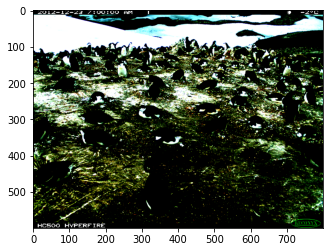

In [ ]:
plt.imshow(imgs[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


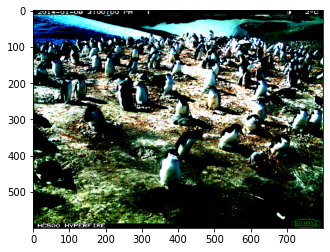

In [ ]:
plt.imshow(new_image)

103.73796
108.48913
(75, 100, 1)


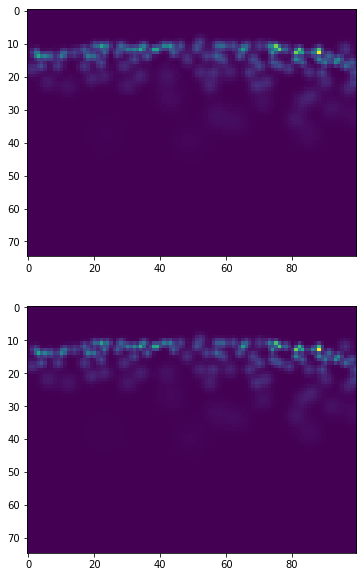

In [24]:
y_pred = model(imgs)
print(gt[2].sum())
print(y_pred[2].numpy().sum())
print(y_pred[2].shape)
fig,ax = plt.subplots(2, figsize=(10,10))
ax[0].imshow(y_pred[2].numpy().reshape(75,100))
ax[1].imshow(gt[2])

Time to run some experiments: step 1, make sure model has capacity to memorize an example

In [ ]:
del model__memorize

In [ ]:
imgs, gt = next(image_generator(img_paths, 32))

In [ ]:
imgs[0].max()

1.0

In [ ]:
gt.shape

(32, 75, 100)

In [ ]:

model__memorize = CrowdNet()
model__memorize.fit(imgs[:2],gt[:2], epochs=2, verbose= 2)

Epoch 1/2
1/1 - 2s - loss: 0.2559 - mse: 0.0027 - mae: 0.0164 - 2s/epoch - 2s/step
Epoch 2/2
1/1 - 0s - loss: 0.2559 - mse: 0.0027 - mae: 0.0164 - 251ms/epoch - 251ms/step


In [ ]:
print(imgs[:1].shape)

(1, 600, 800, 3)


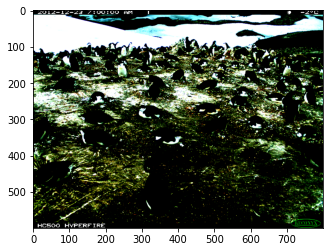

In [ ]:
plt.imshow(imgs[:1][0])

gt: 148.28964233398438
883.3091747760773
(75, 100, 1)


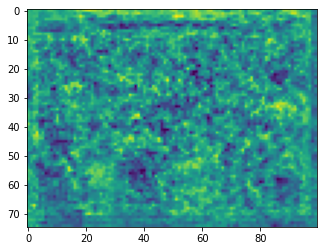

In [ ]:
y_mem = model_presentation(imgs[4:7])
print(f"gt: {gt[5].sum()}")
print(y_mem[1].numpy().sum() * 255)
print(y_mem[1].shape)
plt.imshow(y_mem[1].numpy().reshape(75,100))

In [ ]:
model_presentation()

In [ ]:
euclidean_distance_loss(gt[0], y_mem[0].numpy().reshape(75,100))

<tf.Tensor: shape=(75, 100), dtype=float32, numpy=
array([[3.22823907e-05, 0.00000000e+00, 7.80072951e-05, ...,
        0.00000000e+00, 2.51195539e-04, 3.04904534e-04],
       [0.00000000e+00, 0.00000000e+00, 1.71460386e-04, ...,
        1.43128986e-04, 1.21036202e-04, 1.08063679e-04],
       [0.00000000e+00, 0.00000000e+00, 3.24688765e-04, ...,
        6.67568471e-04, 1.40994074e-04, 2.57442676e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 3.76667856e-04, ...,
        3.22139502e-04, 1.83080221e-04, 2.85394024e-04],
       [0.00000000e+00, 7.42904240e-06, 2.20031652e-04, ...,
        1.97384914e-04, 6.80195590e-05, 1.05525585e-04],
       [0.00000000e+00, 0.00000000e+00, 1.22004836e-04, ...,
        2.81814282e-04, 1.10006826e-04, 6.06602880e-05]], dtype=float32)>

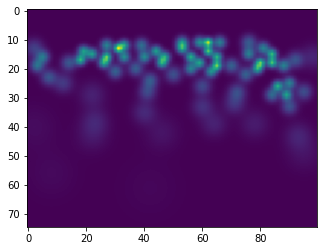

In [ ]:
plt.imshow(gt[0])

In [ ]:
import random

print(img_paths[:5])
random.shuffle(img_paths)
print(img_paths[:5])
train_data = img_paths[:810]
test_data = img_paths[810:]

['/content/content/BAILa/BAILa2014a_000891.JPG', '/content/content/BAILa/BAILa2014a_004607.JPG', '/content/content/BAILa/BAILa2014a_001153.JPG', '/content/content/BAILa/BAILa2014a_000861.JPG', '/content/content/BAILa/BAILa2014a_003774.JPG']
['/content/content/BAILa/BAILa2014a_003894.JPG', '/content/content/BAILa/BAILa2014a_005188.JPG', '/content/content/BAILa/BAILa2014a_001549.JPG', '/content/content/BAILa/BAILa2014a_003761.JPG', '/content/content/BAILa/BAILa2014a_005023.JPG']


In [ ]:
train_gen = image_generator(train_data,2)

In [ ]:
del model_presentation

In [ ]:
model_presentation = CrowdNet()
model_presentation.fit_generator(train_gen,epochs=100,steps_per_epoch= 50, verbose=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
50/50 [==============================] - 20s 366ms/step - loss: 0.1578 - mse: 0.0014 - mae: 0.0107
Epoch 2/100
50/50 [==============================] - 18s 365ms/step - loss: 0.1509 - mse: 0.0014 - mae: 0.0100
Epoch 3/100
50/50 [==============================] - 18s 366ms/step - loss: 0.1443 - mse: 0.0013 - mae: 0.0094
Epoch 4/100
50/50 [==============================] - 18s 365ms/step - loss: 0.1527 - mse: 0.0015 - mae: 0.0100
Epoch 5/100
50/50 [==============================] - 18s 366ms/step - loss: 0.1502 - mse: 0.0014 - mae: 0.0101
Epoch 6/100
50/50 [==============================] - 68s 1s/step - loss: 0.1364 - mse: 0.0012 - mae: 0.0090
Epoch 7/100
50/50 [==============================] - 18s 366ms/step - loss: 0.1489 - mse: 0.0014 - mae: 0.0098
Epoch 8/100
50/50 [==============================] - 18s 365ms/step - loss: 0.1551 - mse: 0.0014 - mae: 0.0104
Epoch 9/100
50/50 [==============================] - 18s 367ms/step - loss: 0.1570 - mse: 0.0015 - mae: 0.0104
Epoc

In [ ]:
y_preds = []
y_trues = []
for i in range(len(test_data)):
    img = get_input(test_data[i])
    gt = get_output(test_data[i][:22] + '_gt' + test_data[i][22:].replace('.JPG','_gt.h5'))
    y_preds.append(model_presentation(tf.reshape(img, (-1,600,800,3))))
    y_trues.append(gt)



In [ ]:
y_preds = np.array(y_preds)
y_preds = np.reshape(y_preds, (202,75,100))

y_trues = np.array(y_trues)
y_trues = np.reshape(y_trues, (202,75,100))
y_preds.shape

(202, 75, 100)

In [ ]:
tf.keras.metrics.mean_squared_error(np.array(y_trues), np.array(y_preds)).numpy().sum()

19.161097

In [ ]:
tf.keras.metrics.mean_absolute_error(np.array(y_trues), np.array(y_preds)).numpy().sum()

143.71126

In [ ]:
from sklearn.metrics import mean_squared_error
mse = 0
y_preds[0].shape
for i in range(len(y_preds)):
    mse += mean_squared_error(y_preds[i], y_trues[i])
print(mse)

0.25548129733661895


In [ ]:
y_preds_og = []
y_trues_og = []
for i in range(len(test_data)):
    img = get_input(test_data[i])
    gt = get_output(test_data[i][:22] + '_gt' + test_data[i][22:].replace('.JPG','_gt.h5'))
    y_preds_og.append(model__memorize(tf.reshape(img, (-1,600,800,3))))
    y_trues_og.append(gt)


In [ ]:
y_preds_og = np.array(y_preds_og)
y_preds_og = np.zeros((202,75,100))

y_trues_og = np.array(y_trues_og)
y_trues_og = np.reshape(y_trues_og, (202,75,100))

tf.keras.metrics.mean_squared_error(np.array(y_trues_og), np.array(y_preds_og)).numpy().sum()

0.0

In [ ]:
tf.keras.metrics.mean_absolute_error(np.array(y_trues_og), np.array(y_preds_og)).numpy().sum()

0.0